# DATA setup 

M = # surgeons

R = # of rooms 

J = info for patients to be scheduled

In [27]:
M = 4
R = 3

# key: surgery type, value: list at index 0 is list of surgeons that can do the surgery, index 2 is the length of the surgery 
surgery = {1: [[1,2], 5],
            2: [[2,3], 3],
            3: [[4], 1], 
            4: [[1,2,3], 6],
            5: [[2,3], 3],
            6: [[1], 8] }



# setup: {patient id: {'surgery_type': surgery_id,
                # 'pj': surgery[surgery_id][1],
                # 'wj': 0.5,
                # 'mi': surgery[surgery_id][0]}}

J = {1: {'surgery_type': 1,
        'pj': surgery[1][1],
        'wj': 0.5,
        'mi': surgery[1][0]},
    2: {'surgery_type': 2,
        'pj': surgery[2][1], 
        'wj': 0.1,
        'mi': surgery[2][0]},
    3: {'surgery_type': 3,
        'pj': surgery[3][1],
        'wj': 0.8,
        'mi': surgery[3][0]},
    4: {'surgery_type': 4,
        'pj': surgery[4][1],
        'wj': 0.3,
        'mi': surgery[4][0]},
    5: {'surgery_type': 3,
        'pj': surgery[3][1],
        'wj': 0.5,
        'mi': surgery[3][0]},
    6: {'surgery_type': 3,
        'pj': surgery[3][1],
        'wj': 0.3,
        'mi': surgery[3][0]}, 
    7: {'surgery_type': 5,
        'pj': surgery[5][1],
        'wj': 0.6,
        'mi': surgery[5][0]},
    8: {'surgery_type': 5,
        'pj': surgery[5][1],
        'wj': 0.8,
        'mi': surgery[5][0]},
    9: {'surgery_type': 6,
        'pj': surgery[6][1],
        'wj': 1,
        'mi': surgery[6][0]},
    10: {'surgery_type': 5,
        'pj': surgery[5][1],
        'wj': 0.3,
        'mi': surgery[5][0]}
    }

# order jobs by priority - WSPT

In [28]:
priorities = {}

for job in J.keys():
    if J[job]['wj'] == 1: # weight of 1 means emergency surgery, therefore is put at front of queue 
        priority = 1
        priorities[job] = priority
    else:
        priority = J[job]['wj'] / J[job]['pj']
        priorities[job] = priority

ordered_priority = dict(sorted(priorities.items(), key=lambda x:x[1], reverse = True))
ordered_priority

{9: 1,
 3: 0.8,
 5: 0.5,
 6: 0.3,
 8: 0.26666666666666666,
 7: 0.19999999999999998,
 1: 0.1,
 10: 0.09999999999999999,
 4: 0.049999999999999996,
 2: 0.03333333333333333}

# Assign jobs to machines 

In [29]:
Mi = {}
for m in range(1, M+1):
    Mi[m] = []

for job in ordered_priority.keys():
    len_of_assigned_machine = 1000
    machine_assignment = 0
    for m in J[job]['mi']:
        if len(Mi[m]) < len_of_assigned_machine:
            machine_assignment = m
            len_of_assigned_machine = len(Mi[m])

    Mi[machine_assignment].append(job)
    J[job]['assigned_machine'] = machine_assignment

J

{1: {'surgery_type': 1,
  'pj': 5,
  'wj': 0.5,
  'mi': [1, 2],
  'assigned_machine': 1},
 2: {'surgery_type': 2,
  'pj': 3,
  'wj': 0.1,
  'mi': [2, 3],
  'assigned_machine': 2},
 3: {'surgery_type': 3, 'pj': 1, 'wj': 0.8, 'mi': [4], 'assigned_machine': 4},
 4: {'surgery_type': 4,
  'pj': 6,
  'wj': 0.3,
  'mi': [1, 2, 3],
  'assigned_machine': 3},
 5: {'surgery_type': 3, 'pj': 1, 'wj': 0.5, 'mi': [4], 'assigned_machine': 4},
 6: {'surgery_type': 3, 'pj': 1, 'wj': 0.3, 'mi': [4], 'assigned_machine': 4},
 7: {'surgery_type': 5,
  'pj': 3,
  'wj': 0.6,
  'mi': [2, 3],
  'assigned_machine': 3},
 8: {'surgery_type': 5,
  'pj': 3,
  'wj': 0.8,
  'mi': [2, 3],
  'assigned_machine': 2},
 9: {'surgery_type': 6, 'pj': 8, 'wj': 1, 'mi': [1], 'assigned_machine': 1},
 10: {'surgery_type': 5,
  'pj': 3,
  'wj': 0.3,
  'mi': [2, 3],
  'assigned_machine': 2}}

# Scheduling to rooms 

In [30]:
Rk = {} #room scheduling object 
room_available_at = [] # when is room (index) available 
machines_in_service = [] # what machines (value) are in what room (index)
machine_available_at = [] # when (value) is the machine (index corresponding to above list) avaialble at 
time_in_day = [] # time of day (value) when checking in on a room (index)

for r in range(1, R+1):
    Rk[r] = []
    room_available_at.append(0)
    machines_in_service.append(0)
    machine_available_at.append(0)
    time_in_day.append(0)


# copy of dict to remove from 
remaining_jobs = ordered_priority.copy()

# start time 
t = 0
while t <= 60 and len(remaining_jobs) != 0:
    
    next_time_check = min(room_available_at)

    # check in each room 
    for r in Rk.keys():

        # check to see if room is available or still in use - else try again later 
        if room_available_at[r-1] <= t:

            # remove sergeons from room if they are done prev surgery 
            machine_available_at = [t if x <= t else x for x in machine_available_at]
            machines_in_service = [0 if machine_available_at[machines_in_service.index(x)] <= t else x for x in machines_in_service]
              
            # next patient 
            candidate_job = list(remaining_jobs.keys())[0]

            if time_in_day[r-1] + J[candidate_job]['pj'] +  0.5 <= 12 and J[candidate_job]['assigned_machine'] not in machines_in_service:
                
                # accept job
                job = candidate_job 
            
                # add surgeon start and end times to room list 
                Rk[r].append({'job': job, 
                    'machine': J[job]['assigned_machine'],
                    'start': t, 
                    'end': t + J[job]['pj']
                    })

                room_available_at[r-1] = t + J[job]['pj'] + 0.5
                machines_in_service[r-1] = J[job]['assigned_machine']
                machine_available_at[r-1] = t + J[job]['pj']
                next_time_check = min(room_available_at)

                if t + J[job]['pj'] + 0.5 <= 12:
                    time_in_day[r-1] = t + J[job]['pj'] + 0.5
                else:
                    time_in_day[r-1] = 0

                if t + J[job]['pj'] + 0.5 < next_time_check:
                    next_time_check = t + J[job]['pj'] + 0.5
                    
                remaining_jobs.pop(job)
                if len(remaining_jobs) == 0:
                    break
           
            else:

                candidate_job = None 
                for job in remaining_jobs.keys():
                    if time_in_day[r-1] + J[job]['pj'] + 0.5 <= 12 and J[job]['assigned_machine'] not in machines_in_service:
                        candidate_job = job
                        
                if candidate_job:
    
                    job = candidate_job 

                    Rk[r].append({'job': job, 
                    'machine': J[job]['assigned_machine'],
                    'start': t, 
                    'end': t + J[job]['pj']
                    })

                    room_available_at[r-1] = t + J[job]['pj'] + 0.5
                    machines_in_service[r-1] = J[job]['assigned_machine']
                    machine_available_at[r-1] = t + J[job]['pj']
                    next_time_check = min(room_available_at)

                    if t + J[job]['pj'] + 0.5 <= 12:
                        time_in_day[r-1] = t + J[job]['pj'] + 0.5
                    else:
                        time_in_day[r-1] = 0

                    if t + J[job]['pj'] + 0.5 < next_time_check:
                        next_time_check = t + J[job]['pj'] + 0.5
                        
                    remaining_jobs.pop(job)
                    if len(remaining_jobs) == 0:
                        break

                else:
                    next_time_check = 12 * (1 + int((t - 1) / 12)) # go to next day
                        
                    time_in_day[r-1] = 0 
                    
                    room_available_at[r-1] = next_time_check
                    machine_available_at[r-1] = next_time_check
                    machines_in_service[r-1] = 0


    t = next_time_check

Rk
        

{1: [{'job': 9, 'machine': 1, 'start': 0, 'end': 8},
  {'job': 4, 'machine': 3, 'start': 12, 'end': 18}],
 2: [{'job': 3, 'machine': 4, 'start': 0, 'end': 1},
  {'job': 5, 'machine': 4, 'start': 1.5, 'end': 2.5},
  {'job': 6, 'machine': 4, 'start': 3.0, 'end': 4.0},
  {'job': 7, 'machine': 3, 'start': 4.5, 'end': 7.5},
  {'job': 1, 'machine': 1, 'start': 12, 'end': 17}],
 3: [{'job': 2, 'machine': 2, 'start': 0, 'end': 3},
  {'job': 8, 'machine': 2, 'start': 3.5, 'end': 6.5},
  {'job': 10, 'machine': 2, 'start': 7.0, 'end': 10.0}]}

# Plot

(0.0, 60.0)

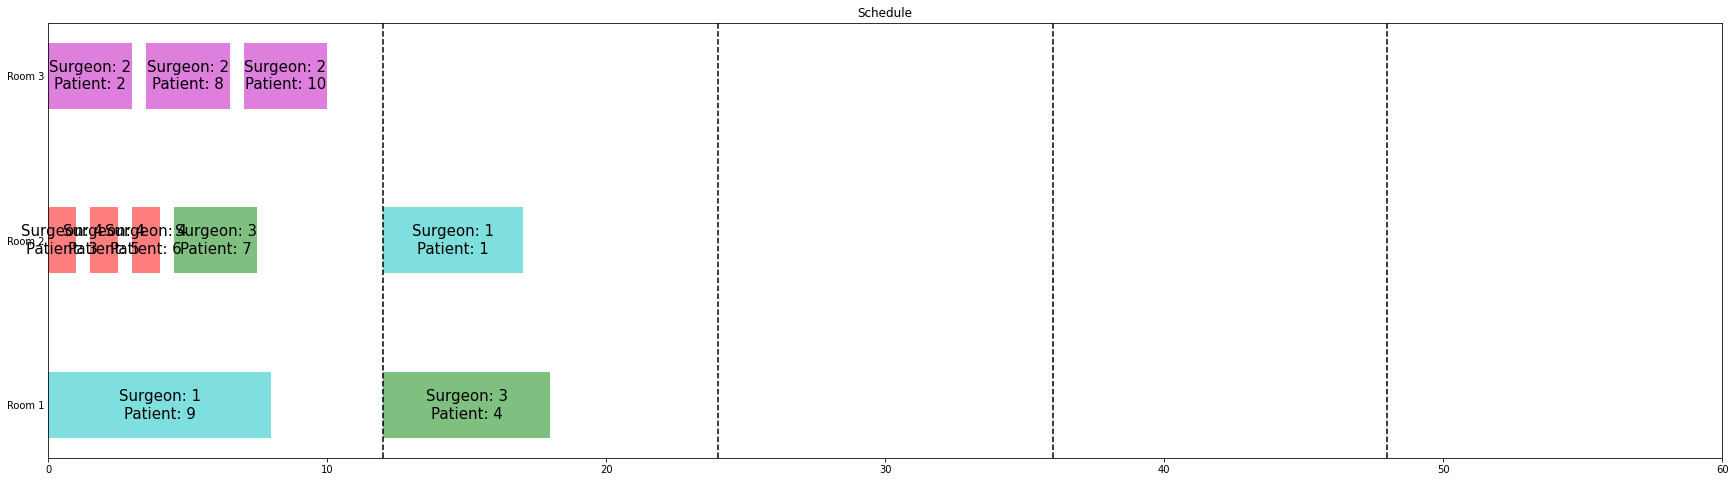

In [31]:
import matplotlib.pyplot as plt

# Define chart parameters
chart_title = "Schedule"
bar_height = 0.4
bar_color1 = 'blue'
bar_color2 = 'green'

colours = ['c', 'm', 'g', 'r', 'b', 'y']

# Set up the chart
fig, ax = plt.subplots(figsize=(30, 8))

# Set up the y-axis
ylabels = [f"Room {i+1}" for i in range(R)]
ypos = range(R)
ax.set_yticks(ypos)
ax.set_yticklabels(ylabels)
ax.tick_params(axis='y', length=0)

for r in Rk.keys():
    jobs_in_room = Rk[r]
    for job in jobs_in_room:
        duration = job['end'] - job['start']
        ax.barh(r-1, duration, height=bar_height, left=job['start'], align='center', alpha=0.5, color=colours[job['machine']-1])
        ax.text(job['start'] + duration / 2, r-1, f"Surgeon: {job['machine']}\nPatient: {job['job']}", ha='center', va='center', color='black', size = 15)

# Add the chart title
ax.set_title(chart_title)

day_idxs = [12, 24, 36, 48]
for x in day_idxs:
    ax.axvline(x=x, color='k', linestyle='--')

xmin = 0
xmax = 60
ax.set_xlim(xmin, xmax)


# Requirements for streamlit

1. form to enter in new "job" (patient) info
    - how long it will take (pj) - maybe dependent on type of surgery 
    - weight of surgery (wj) - maybe based on the cost of the surgery, the comlexity of the surgery or the urgency 
    - what sergeons are qualified to do the surgery - maybe this is autofilled based on surgery type


2. pass vars to run scheduling algo and then plot gantt chart 

fixed inputs include: number of patients and number of surgeons for each surgery type
